In [1]:
import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings

In [2]:
print('Pytorch version: ', torch.__version__)
print('Pandas version: ', pd.__version__)
print('Numpy version: ', np.__version__)

Pytorch version:  2.4.0+cu121
Pandas version:  2.1.4
Numpy version:  1.26.4


#PyTorch Workflow Fundamentals

1. **Getting data ready:**	Data can be almost anything.
2. **Building a model:**	Create a model to learn patterns in the data
3. **Fitting the model to data:** Start training the model to find patterns in data.
4. **Making predictions and evaluating a model:** Evaluate the results.
5. **Saving and loading a model:**	Save and re-use the model.
6. **Putting it all together:**	Combine it all together.

In [3]:
what_were_covering = {1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}

### 1. Data

We don't have a dataset to analyze, but we can create one. We will create a straight line with know parameters and, then, we will train a model to find those parameters.

In [4]:
# Create *known* parameters
weight = 0.9
bias = 0.4

# Create data
start = 0
end = 1
step = 0.01
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:5], y[:5]

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.4000],
         [0.4090],
         [0.4180],
         [0.4270],
         [0.4360]]))

In [5]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(80, 80, 20, 20)

In [6]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):

  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

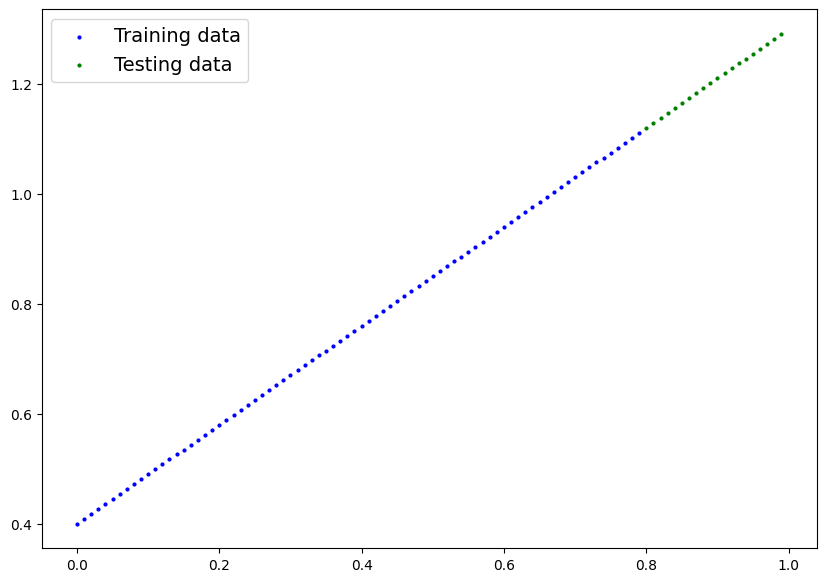

In [7]:
plot_predictions();

### 2. Build a Model


In [8]:
import torch.nn as nn

# Create a Linear Regression model class
class LinearRegressionModel(nn.Module):
  # almost everything in PyTorch is a nn.Module
  # think of this as neural network lego blocks
    def __init__(self):
        super().__init__()
        # start with random weights and bias
        # this will get adjusted as the model learns
        self.weights = nn.Parameter(torch.randn(1, dtype=torch.float),
                                   requires_grad=True)
        self.bias = nn.Parameter(torch.randn(1, dtype=torch.float),
                                requires_grad=True)

    # Forward defines the computation in the model
    # "x" is the input data (e.g. training/testing features)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # this is the linear regression formula (y = m*x + b)
        return self.weights * x + self.bias

In [9]:
# Set manual seed since nn.Parameter are randomly initialized
torch.manual_seed(42)

# Create an instance of the model
# this is a subclass of nn.Module that contains nn.Parameter(s)
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [10]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [11]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)

In [12]:
# Check the predictions
print(f"Number of testing samples: {len(X_test)}")
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 20
Number of predictions made: 20
Predicted values:
tensor([[0.3982],
        [0.4015],
        [0.4049],
        [0.4083],
        [0.4116],
        [0.4150],
        [0.4184],
        [0.4217],
        [0.4251],
        [0.4285],
        [0.4318],
        [0.4352],
        [0.4386],
        [0.4419],
        [0.4453],
        [0.4487],
        [0.4520],
        [0.4554],
        [0.4588],
        [0.4621]])


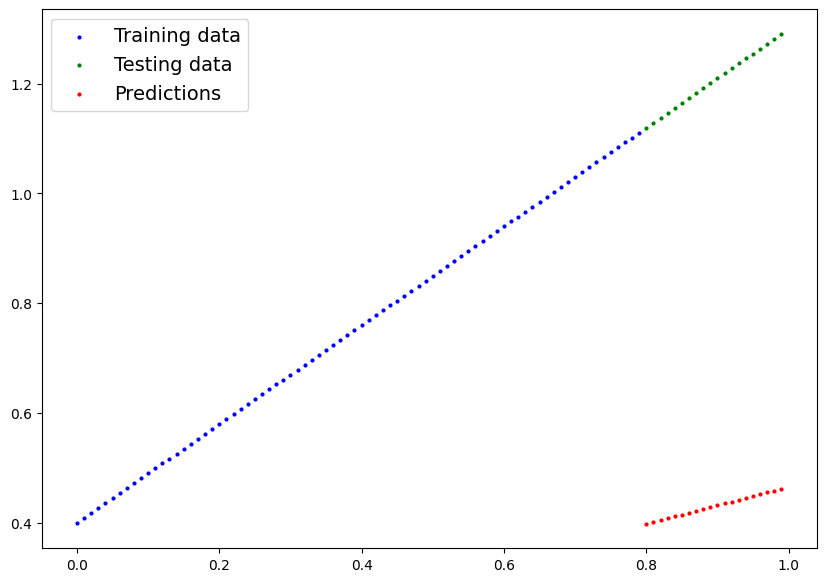

In [13]:
plot_predictions(predictions=y_preds)

### 3. Train Model

In [14]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(
        params=model_0.parameters(), # parameters of target model to optimize
        lr=0.01) # learning rate

# lr > how much the optimizer should change parameters at each step
# higher=more (less stable), lower=less (might take a long time)

In [15]:
torch.manual_seed(42)

# Set the number of epochs
# how many times the model will pass over the training data
epochs = 200

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside
    y_pred = model_0(X_train)
    # print(y_pred)

    # 2. Calculate the loss
    # how different are our models predictions to the ground truth
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      # predictions come in torch.float datatype,
      # so comparisons need to be done with tensors of the same type
      test_loss = loss_fn(test_pred, y_test.type(torch.float))

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss}"
                  f" | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.4936978816986084 | MAE Test Loss: 0.761817455291748 
Epoch: 10 | MAE Train Loss: 0.3780953288078308 | MAE Test Loss: 0.62646484375 
Epoch: 20 | MAE Train Loss: 0.2624928951263428 | MAE Test Loss: 0.49111247062683105 
Epoch: 30 | MAE Train Loss: 0.1510513424873352 | MAE Test Loss: 0.3593316674232483 
Epoch: 40 | MAE Train Loss: 0.09677731245756149 | MAE Test Loss: 0.26717811822891235 
Epoch: 50 | MAE Train Loss: 0.07799170911312103 | MAE Test Loss: 0.2119361162185669 
Epoch: 60 | MAE Train Loss: 0.07086177170276642 | MAE Test Loss: 0.1807021200656891 
Epoch: 70 | MAE Train Loss: 0.06666945666074753 | MAE Test Loss: 0.16247165203094482 
Epoch: 80 | MAE Train Loss: 0.06310106068849564 | MAE Test Loss: 0.1500171273946762 
Epoch: 90 | MAE Train Loss: 0.059640150517225266 | MAE Test Loss: 0.14030566811561584 
Epoch: 100 | MAE Train Loss: 0.056215085089206696 | MAE Test Loss: 0.1319701075553894 
Epoch: 110 | MAE Train Loss: 0.05278903990983963 | MAE Test Loss: 0.1

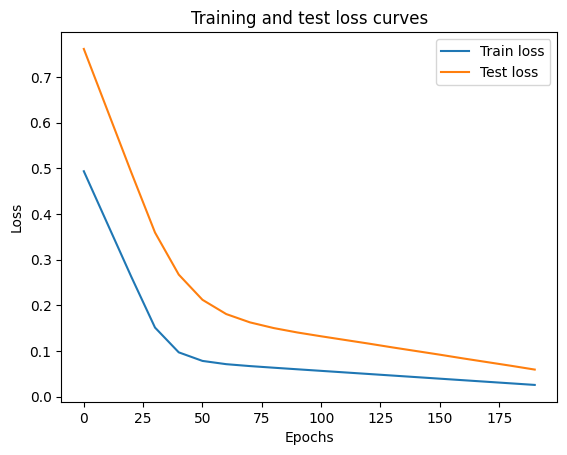

In [16]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [17]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.7907])), ('bias', tensor([0.4461]))])

And the original values for weights and bias are:
weights: 0.9, bias: 0.4


### 4. Making Predictions

In [18]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)
  y_preds = model_0(X_test)
y_preds

tensor([[1.0786],
        [1.0865],
        [1.0944],
        [1.1023],
        [1.1102],
        [1.1181],
        [1.1260],
        [1.1339],
        [1.1419],
        [1.1498],
        [1.1577],
        [1.1656],
        [1.1735],
        [1.1814],
        [1.1893],
        [1.1972],
        [1.2051],
        [1.2130],
        [1.2209],
        [1.2288]])

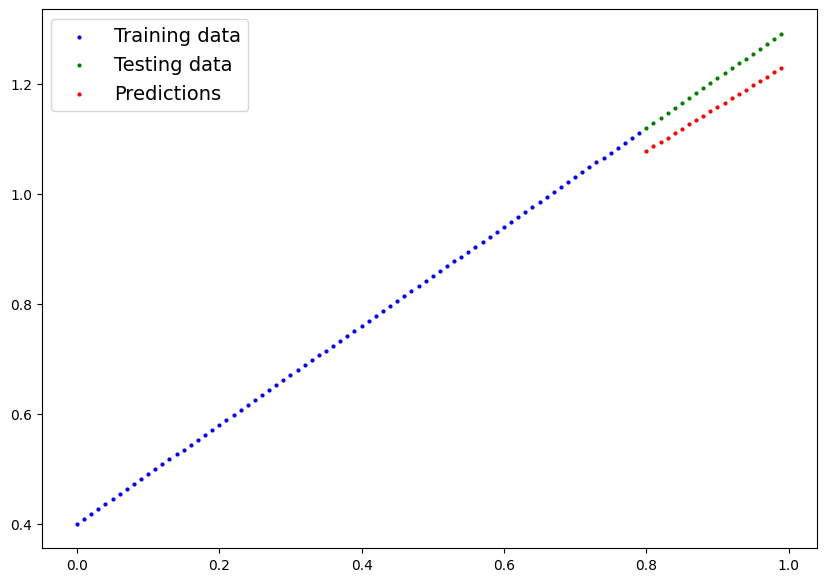

In [19]:
plot_predictions(predictions=y_preds)

### 5. Saving and loading a PyTorch model

In [20]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [21]:
# Check the saved file path
!ls -l models/01_pytorch_workflow_model_0.pth

-rw-r--r-- 1 root root 1680 Sep  9 01:27 models/01_pytorch_workflow_model_0.pth


In [22]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<ipython-input-22-c3119fcaa06c>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<All keys matched successfully>

In [23]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test) # perform a forward pass on the test data with the loaded model

In [24]:
# Compare previous model predictions with loaded model predictions (these should be the same)
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

### 6. Putting it all together

In [25]:
# Import PyTorch and matplotlib
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.4.0+cu121'

In [26]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [27]:
# Create weight and bias
weight = 0.6
bias = 0.5

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze, errors will happen later on (shapes within linear layers)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.5000],
         [0.5120],
         [0.5240],
         [0.5360],
         [0.5480],
         [0.5600],
         [0.5720],
         [0.5840],
         [0.5960],
         [0.6080]]))

In [28]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

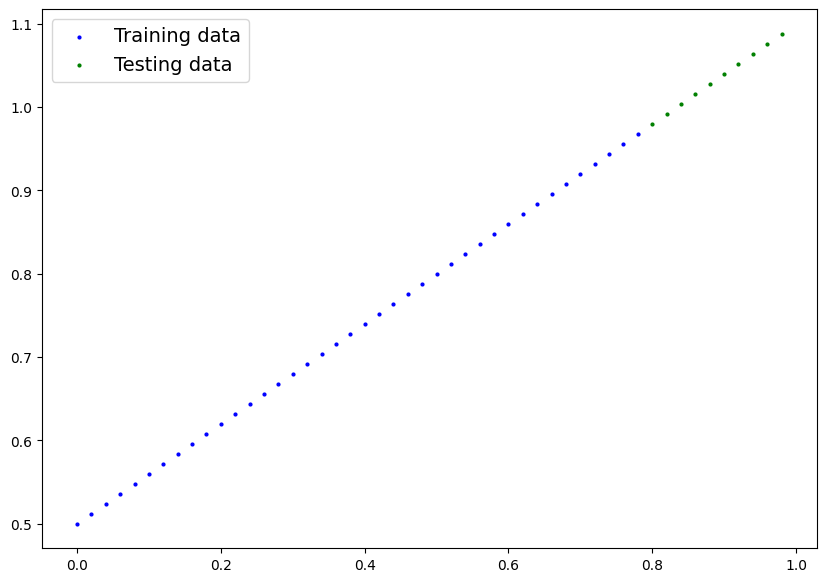

In [29]:
# Note: If you've reset your runtime, this function won't work,
# you'll have to rerun the cell above where it's instantiated.
plot_predictions(X_train, y_train, X_test, y_test)

In [30]:
# Subclass nn.Module to make our model
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters
        self.linear_layer = nn.Linear(in_features=1,
                                      out_features=1)

    # Define the forward computation (input data x flows through nn.Linear())
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

# Set the manual seed when creating the model (this isn't always need but is used for demonstrative purposes, try commenting it out and seeing what happens)
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [31]:
# Check model device
next(model_1.parameters()).device

device(type='cpu')

In [32]:
# Set model to GPU if it's availalble, otherwise it'll default to CPU
model_1.to(device) # the device variable was set above to be "cuda" if available or "cpu" if not
next(model_1.parameters()).device

device(type='cuda', index=0)

In [33]:
# Create loss function
loss_fn = nn.L1Loss()

# Create optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), # optimize newly created model's parameters
                            lr=0.01)

In [34]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data on the available device
# Without this, error will happen (not all model/data on device)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_1.train() # train mode is on by default after construction

    # 1. Forward pass
    y_pred = model_1(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad optimizer
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model_1.eval() # put the model in evaluation mode for testing (inference)
    # 1. Forward pass
    with torch.inference_mode():
        test_pred = model_1(X_test)

        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.3941779136657715 | Test loss: 0.46297621726989746
Epoch: 100 | Train loss: 0.0012794822687283158 | Test loss: 0.013745874166488647
Epoch: 200 | Train loss: 0.0012794822687283158 | Test loss: 0.013745874166488647
Epoch: 300 | Train loss: 0.0012794822687283158 | Test loss: 0.013745874166488647
Epoch: 400 | Train loss: 0.0012794822687283158 | Test loss: 0.013745874166488647
Epoch: 500 | Train loss: 0.0012794822687283158 | Test loss: 0.013745874166488647
Epoch: 600 | Train loss: 0.0012794822687283158 | Test loss: 0.013745874166488647
Epoch: 700 | Train loss: 0.0012794822687283158 | Test loss: 0.013745874166488647
Epoch: 800 | Train loss: 0.0012794822687283158 | Test loss: 0.013745874166488647
Epoch: 900 | Train loss: 0.0012794822687283158 | Test loss: 0.013745874166488647


In [35]:
# Find our model's learned parameters
from pprint import pprint # pprint = pretty print, see: https://docs.python.org/3/library/pprint.html
print("The model learned the following values for weights and bias:")
pprint(model_1.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.6031]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.4975], device='cuda:0'))])

And the original values for weights and bias are:
weights: 0.6, bias: 0.5


In [36]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([[0.9800],
        [0.9921],
        [1.0041],
        [1.0162],
        [1.0282],
        [1.0403],
        [1.0524],
        [1.0644],
        [1.0765],
        [1.0886]], device='cuda:0')

In [37]:
predictions=y_preds
predictions

tensor([[0.9800],
        [0.9921],
        [1.0041],
        [1.0162],
        [1.0282],
        [1.0403],
        [1.0524],
        [1.0644],
        [1.0765],
        [1.0886]], device='cuda:0')

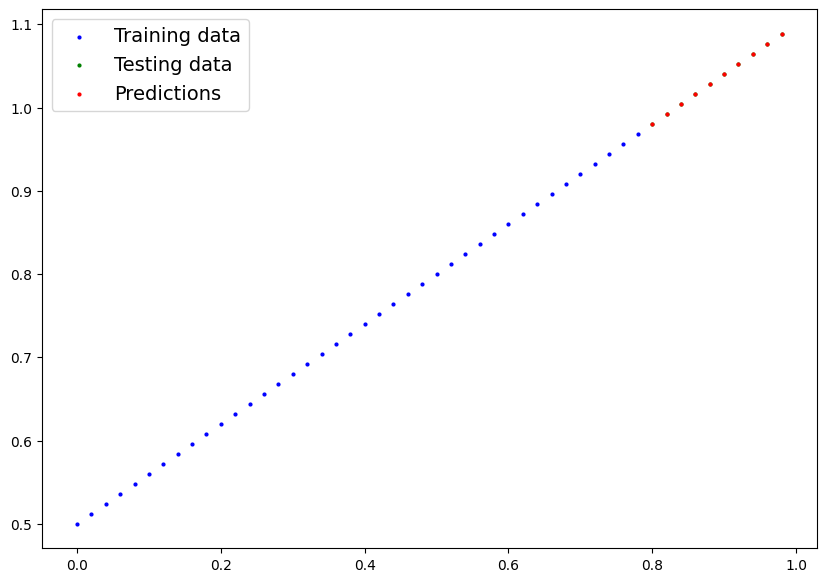

In [42]:
# plot_predictions(predictions=y_preds) # -> won't work... data not on CPU

# Put data on the CPU and plot it

plot_predictions(train_data=X_train.cpu(),
                  train_labels=y_train.cpu(),
                  test_data=X_test.cpu(),
                  test_labels=y_test.cpu(),
                  predictions=y_preds.cpu())

In [43]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [44]:
# Instantiate a fresh instance of LinearRegressionModelV2
loaded_model_1 = LinearRegressionModelV2()

# Load model state dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_1.to(device)

print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")

Loaded model:
LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
cuda:0


<ipython-input-44-c4e3cba863db>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))


In [45]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')